In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-a3/Multi-Label Text Classification Dataset.csv
/kaggle/input/nlp-a3-model/best_model_state.bin


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import time as time
import torch.nn.functional as F
import torch.nn as nn
from transformers import AdamW
import transformers

import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
import tqdm as tqdm
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
start = time.time()
# Read data
df_data = pd.read_csv("/kaggle/input/nlp-a3/Multi-Label Text Classification Dataset.csv")
# data = pd.read_csv("/kaggle/input/nlp-a3/small.csv")
# df_data = df_data.iloc[:10000]

df_data['combined'] = df_data['Title']+'. '+df_data['abstractText']
df_data.drop(columns=["Title","abstractText","meshMajor","pmid","meshid","meshroot"],axis=1, inplace=True)

# Split data into train, validation, test
df_train, df_valid = train_test_split(df_data, random_state=42, test_size=0.2, shuffle=True)
# split test into test and validation datasets
df_train, df_test = train_test_split(df_train, random_state=42, test_size=0.15, shuffle=True)

# print(f"Train: {df_train.shape},  Valid: {df_valid.shape}")
print(f"Train: {df_train.shape},  Test: {df_test.shape},    Valid: {df_valid.shape}")

Train: (34000, 15),  Test: (6000, 15),    Valid: (10000, 15)


In [25]:
# Hyperparameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 8
# LEARNING_RATE = 1e-05


In [12]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['combined'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
#         title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
#             'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [9]:
target_list = list(df_data.columns)
# print(target_list)
if 'combined' in target_list:
    print(target_list)
    target_list.remove('combined')
print(target_list)   


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z', 'combined']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


In [13]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [ ]:
# testing the dataset
next(iter(train_dataset))

In [14]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
   

In [15]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        
        '''for param in self.bert_model.parameters():
            param.requires_grad = False
        for param in self.bert_model.encoder.layer[-1:].parameters():
            param.requires_grad = True'''
        
        # Get the output size of the last layer of the BERT model
        bert_output_size = self.bert_model.config.hidden_size
        print(f'Bert output size:{bert_output_size}')
        '''self.ffn = nn.Sequential(
            nn.LayerNorm(bert_output_size),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(bert_output_size, 512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.LayerNorm(256),
            nn.Linear(256, num_classes)
        )'''
        self.ffn = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(768, num_classes)
            )      

    def forward(self, input_ids, attn_mask):
        # BERT base model output
        output = self.bert_model(input_ids, attention_mask=attn_mask)
        output_dropout = output[1]
#         output_dropout = self.dropout(output.pooler_output)
        
        output = self.ffn(output_dropout)
        
        return output
    
if 'model' in locals():
    del model
    
# Instantiate the model with the correct number of classes
num_classes = len(target_list)
model = BERTClass(num_classes)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)

model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Bert output size:768


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [20]:
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss for multi-label classification

In [21]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [22]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    check = 1
    # set model to training mode
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)

        targets = data['targets'].to(device, dtype=torch.float)

        # forward
        outputs = model(ids, mask)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        # calculate training accuracy
        predictions = (torch.sigmoid(outputs) > 0.5).int()  # apply threshold
        correct_predictions += torch.sum(predictions == targets).item()
        num_samples += targets.size(0)
        # backward
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Update progress bar
        # loop.set_description(f"Epoch [{epoch}/{EPOCHS}]")
        # loop.set_postfix(batch_loss=loss.item())

    # Calculate overall accuracy
    overall_accuracy = correct_predictions / num_samples

    # return trained model, model accuracy, mean loss
    return model, overall_accuracy, np.mean(losses)


In [23]:
def eval_model(validation_loader, model):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_targets = []
    all_predictions = []
    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
#             token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)
            outputs = model(ids, mask)

            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # calculate validation accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()  # apply threshold
            correct_predictions += torch.sum(predictions == targets).item()
            num_samples += targets.size(0)
            
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
    
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    valid_report = classification_report(np.array(all_targets),np.array(all_predictions),output_dict = True, zero_division = 0)
    print(f'For Validation :{ classification_report(np.array(all_targets),np.array(all_predictions),target_names = target_list,output_dict = False, zero_division = 0)}')
    
    overall_accuracy = correct_predictions / num_samples
    
    return overall_accuracy, np.mean(losses)

In [26]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

best_accuracy = 0
# EPOCHS = 5
start = time.time()
initial_lr = 1e-5
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = initial_lr) # eps = 1e-12) 

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model)

#     print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    train_accs.append(train_acc)
    train_losses.append(train_loss)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    '''if epoch < 7:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.75'''
    
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc
    
    print(f'Train_loss{train_loss},Val Loss{val_loss}')

Epoch 1/8


  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.86      0.79      0.82      4606
           B       0.97      0.99      0.98      9276
           C       0.88      0.90      0.89      5284
           D       0.90      0.96      0.92      6157
           E       0.82      0.96      0.88      7842
           F       0.85      0.76      0.80      1762
           G       0.83      0.90      0.86      6660
           H       0.64      0.15      0.24      1272
           I       0.72      0.57      0.63      1159
           J       0.79      0.42      0.55      1141
           L       0.74      0.50      0.59      1486
           M       0.88      0.92      0.90      4280
           N       0.79      0.83      0.81      4519
           Z       0.81      0.74      0.78      1651

   micro avg       0.86      0.86      0.86     57095
   macro avg       0.82      0.74      0.76     57095
weighted avg       0.86      0.86      0.85     57095
 samples a

  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.85      0.81      0.83      4606
           B       0.97      0.99      0.98      9276
           C       0.89      0.90      0.89      5284
           D       0.91      0.94      0.93      6157
           E       0.84      0.93      0.88      7842
           F       0.80      0.80      0.80      1762
           G       0.86      0.85      0.86      6660
           H       0.67      0.14      0.23      1272
           I       0.69      0.63      0.66      1159
           J       0.72      0.57      0.64      1141
           L       0.70      0.56      0.62      1486
           M       0.87      0.93      0.90      4280
           N       0.79      0.83      0.81      4519
           Z       0.80      0.77      0.79      1651

   micro avg       0.86      0.86      0.86     57095
   macro avg       0.81      0.76      0.77     57095
weighted avg       0.86      0.86      0.86     57095
 samples a

  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.78      0.88      0.83      4606
           B       0.97      0.99      0.98      9276
           C       0.94      0.82      0.88      5284
           D       0.91      0.94      0.93      6157
           E       0.84      0.92      0.88      7842
           F       0.81      0.80      0.81      1762
           G       0.81      0.92      0.86      6660
           H       0.62      0.28      0.38      1272
           I       0.68      0.66      0.67      1159
           J       0.68      0.61      0.64      1141
           L       0.73      0.54      0.62      1486
           M       0.89      0.91      0.90      4280
           N       0.79      0.83      0.81      4519
           Z       0.76      0.81      0.78      1651

   micro avg       0.85      0.87      0.86     57095
   macro avg       0.80      0.78      0.78     57095
weighted avg       0.85      0.87      0.86     57095
 samples a

  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.84      0.81      0.82      4606
           B       0.97      0.98      0.98      9276
           C       0.88      0.90      0.89      5284
           D       0.93      0.91      0.92      6157
           E       0.84      0.90      0.87      7842
           F       0.81      0.79      0.80      1762
           G       0.83      0.90      0.86      6660
           H       0.66      0.21      0.32      1272
           I       0.72      0.58      0.65      1159
           J       0.71      0.59      0.64      1141
           L       0.69      0.57      0.62      1486
           M       0.90      0.87      0.88      4280
           N       0.83      0.77      0.80      4519
           Z       0.82      0.73      0.77      1651

   micro avg       0.87      0.85      0.86     57095
   macro avg       0.82      0.75      0.77     57095
weighted avg       0.86      0.85      0.85     57095
 samples a

  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.83      0.82      0.83      4606
           B       0.97      0.99      0.98      9276
           C       0.87      0.91      0.89      5284
           D       0.91      0.94      0.92      6157
           E       0.84      0.91      0.87      7842
           F       0.77      0.81      0.79      1762
           G       0.81      0.91      0.86      6660
           H       0.61      0.27      0.38      1272
           I       0.72      0.58      0.64      1159
           J       0.70      0.59      0.64      1141
           L       0.66      0.57      0.61      1486
           M       0.87      0.92      0.89      4280
           N       0.80      0.80      0.80      4519
           Z       0.84      0.71      0.77      1651

   micro avg       0.85      0.87      0.86     57095
   macro avg       0.80      0.77      0.78     57095
weighted avg       0.85      0.87      0.85     57095
 samples a

  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.84      0.79      0.82      4606
           B       0.97      0.98      0.98      9276
           C       0.85      0.93      0.88      5284
           D       0.92      0.92      0.92      6157
           E       0.85      0.89      0.87      7842
           F       0.81      0.78      0.80      1762
           G       0.86      0.84      0.85      6660
           H       0.58      0.32      0.41      1272
           I       0.68      0.64      0.66      1159
           J       0.68      0.60      0.64      1141
           L       0.65      0.58      0.61      1486
           M       0.89      0.89      0.89      4280
           N       0.81      0.78      0.80      4519
           Z       0.80      0.75      0.77      1651

   micro avg       0.86      0.85      0.86     57095
   macro avg       0.80      0.76      0.78     57095
weighted avg       0.86      0.85      0.85     57095
 samples a

  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.82      0.79      0.81      4606
           B       0.96      0.99      0.98      9276
           C       0.88      0.90      0.89      5284
           D       0.92      0.92      0.92      6157
           E       0.82      0.94      0.88      7842
           F       0.81      0.78      0.79      1762
           G       0.82      0.89      0.86      6660
           H       0.56      0.33      0.42      1272
           I       0.67      0.63      0.65      1159
           J       0.69      0.60      0.64      1141
           L       0.65      0.58      0.61      1486
           M       0.86      0.93      0.89      4280
           N       0.77      0.82      0.79      4519
           Z       0.78      0.78      0.78      1651

   micro avg       0.85      0.87      0.86     57095
   macro avg       0.79      0.78      0.78     57095
weighted avg       0.84      0.87      0.85     57095
 samples a

  0%|          | 0/2125 [00:00<?, ?it/s]

For Validation :              precision    recall  f1-score   support

           A       0.83      0.79      0.81      4606
           B       0.97      0.98      0.98      9276
           C       0.89      0.88      0.89      5284
           D       0.91      0.93      0.92      6157
           E       0.84      0.90      0.87      7842
           F       0.82      0.76      0.79      1762
           G       0.85      0.83      0.84      6660
           H       0.54      0.35      0.43      1272
           I       0.66      0.65      0.66      1159
           J       0.66      0.59      0.62      1141
           L       0.65      0.57      0.61      1486
           M       0.88      0.89      0.89      4280
           N       0.78      0.80      0.79      4519
           Z       0.79      0.76      0.78      1651

   micro avg       0.85      0.85      0.85     57095
   macro avg       0.79      0.76      0.78     57095
weighted avg       0.85      0.85      0.85     57095
 samples a

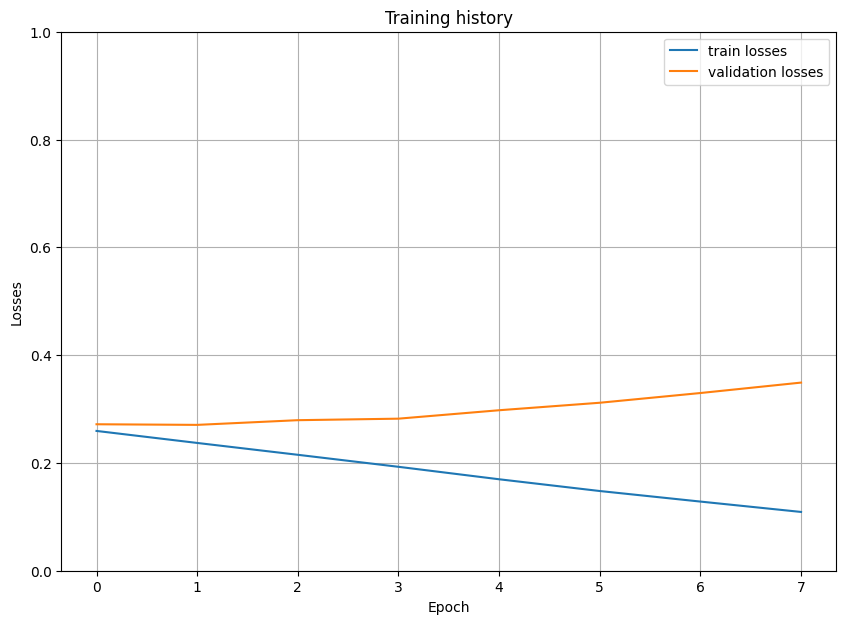

In [36]:
# print(val_acc,train_acc)

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.title('Training history')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()
     

In [19]:
# Loading pretrained model
model = BERTClass(num_classes)
model.load_state_dict(torch.load("/kaggle/input/nlp-a3-model/best_model_state.bin"))
model = model.to(device)

Bert output size:768


In [32]:
def test_model(test_data_loader, model):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_targets = []
    all_predictions = []
    
    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for data in test_data_loader:
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
#             token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)
            outputs = model(ids, mask)

            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # calculate validation accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()  # apply threshold
            correct_predictions += torch.sum(predictions == targets).item()
            num_samples += targets.size(0)
            
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
    
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    valid_report = classification_report(np.array(all_targets),np.array(all_predictions),output_dict = True, zero_division = 0)
    print(f'For Test :\n{ classification_report(np.array(all_targets),np.array(all_predictions),target_names = target_list,output_dict = False, zero_division = 0)}')
    
    overall_accuracy = correct_predictions / num_samples
    
    return overall_accuracy, np.mean(losses)

In [33]:
test_acc, test_loss = test_model(test_data_loader, model)
print(f'Test Loss{test_loss}')

For Test :
              precision    recall  f1-score   support

           A       0.83      0.79      0.81      2818
           B       0.97      0.99      0.98      5620
           C       0.89      0.88      0.89      3163
           D       0.92      0.93      0.92      3719
           E       0.85      0.90      0.88      4754
           F       0.82      0.74      0.78      1061
           G       0.86      0.84      0.85      4027
           H       0.53      0.32      0.40       755
           I       0.69      0.69      0.69       716
           J       0.67      0.64      0.65       688
           L       0.68      0.56      0.61       938
           M       0.88      0.90      0.89      2577
           N       0.80      0.80      0.80      2804
           Z       0.77      0.77      0.77       959

   micro avg       0.86      0.85      0.86     34599
   macro avg       0.80      0.77      0.78     34599
weighted avg       0.86      0.85      0.85     34599
 samples avg   

In [34]:
train_csv_path = "train.csv"
valid_csv_path = "valid.csv"
test_csv_path = "test.csv"

# Save DataFrames to CSV files
df_train.to_csv(train_csv_path, index=False)
df_valid.to_csv(valid_csv_path, index=False)
df_test.to_csv(test_csv_path, index=False)

print("CSV files saved successfully.")

CSV files saved successfully.


In [ ]:
# print(len(target_list))
# print(target_list)